In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)
library(data.table)
library(scales)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
library('ggplot2')
library('Cairo')
CairoFonts(
regular="Sans:style=Medium",
bold="Sans:style=Bold",
italic="Sans:style=Oblique",
bolditalic="Sans:style=BoldOblique")

In [3]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res=150, repr.plot.pointsize=12)

In [4]:
figures_path = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/"
tables_path = "/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/tables/"
source_files = "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [5]:
sce = readRDS("/nfs/team205/vk8/processed_data/muscle/data_v3/updated_icm_snuclei/ICM_myonuclei_scvi1_dbrm_sce_2023-05-11.Rds")
sce = sce [, (sce$DonorID!='343B')]

In [6]:
length(unique(sce$SampleID))

[1] 20

In [7]:
avrg_nhd_size = length(unique(sce$SampleID))*3
print(avrg_nhd_size)

sce$Age_group = factor(sce$Age_group, levels = c("young", "old"))

milo_obj = Milo(sce)
milo_obj = buildGraph(milo_obj, k = 57, d = 30, reduced.dim = "X_scVI")
milo_obj = makeNhoods(milo_obj, prop = 0.1, k = 57, d=30, refined = TRUE, reduced_dims = "X_scVI")
nhds = plotNhoodSizeHist(milo_obj)
milo_obj = countCells(milo_obj, meta.data = as.data.frame(colData(milo_obj)), sample="SampleID")
head(nhoodCounts(milo_obj))
dim(nhoodCounts(milo_obj))
summary(rowSums(nhoodCounts(milo_obj)))

sample_order = colnames(nhoodCounts(milo_obj))

[1] 60


Constructing kNN graph with k:57

Checking valid object

Running refined sampling with reduced_dim

Checking meta.data validity

Counting cells in neighbourhoods

  [[ suppressing 20 column names ‘mus_SNuc7468111’, ‘5386STDY7600836’, ‘5386STDY7600837’ ... ]]



6 x 20 sparse Matrix of class "dgCMatrix"
                                                    
1  8  2 .  . . . 1 2 1 10 10  1 . 16 .  .  .  . 28 .
2 22  6 8 30 . . . 3 1  5  5 13 .  4 2 45  1  2  . .
3  .  2 2  4 . 2 5 7 .  2  4  5 3  . 1 22  3  8  . .
4  7 11 6  3 4 2 2 7 .  .  .  1 .  9 3 70  .  1  . .
5 26  8 9 32 . . 2 1 5  2  1  3 .  7 .  6  2  2  . .
6  5  3 5  3 . . 2 5 . 15 22  5 6 13 .  5 10 10  . .

[1] 6135   20

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  59.00   80.00   95.00   99.08  114.00  215.00 

In [8]:
colData(milo_obj)

DataFrame with 65890 rows and 58 columns
                                          SampleID          barcode
                                       <character>      <character>
mus_SNuc7468111-ACACCCTGTTTAGGAA   mus_SNuc7468111 ACACCCTGTTTAGGAA
mus_SNuc7468111-GACTACAGTAGCACGA   mus_SNuc7468111 GACTACAGTAGCACGA
mus_SNuc7468111-ATCCACCGTTGTTTGG   mus_SNuc7468111 ATCCACCGTTGTTTGG
mus_SNuc7468111-CGTGTAACATTAGCCA   mus_SNuc7468111 CGTGTAACATTAGCCA
mus_SNuc7468111-ATAACGCCACATGACT   mus_SNuc7468111 ATAACGCCACATGACT
...                                            ...              ...
WS_A_SKM10691779-AGGTTACAGGTACATA WS_A_SKM10691779 AGGTTACAGGTACATA
WS_A_SKM10691779-ACTCCCACAGACAATA WS_A_SKM10691779 ACTCCCACAGACAATA
WS_A_SKM10691779-CATTCTATCCCTTGGT WS_A_SKM10691779 CATTCTATCCCTTGGT
WS_A_SKM10691779-GTTGCGGCACCATTCC WS_A_SKM10691779 GTTGCGGCACCATTCC
WS_A_SKM10691779-ATAGACCGTGGCCTCA WS_A_SKM10691779 ATAGACCGTGGCCTCA
                                  concat_sample_no     DonorID         Sex


In [9]:
dim(milo_obj)

[1] 33538 65890

In [10]:
exp_design <- data.frame(colData(milo_obj))[,c("SampleID","DonorID", "X10X_version", "Sex", "Donor_type",
                                               "BMI", "Ventilation_cat", "Age_group")]

## Convert batch info from integer to factor
#exp_design$sequencing.batch <- as.factor(exp_design$sequencing.batch) 
exp_design = distinct(exp_design)
rownames(exp_design) = exp_design$SampleID
exp_design = exp_design[sample_order,]


In [11]:
milo_obj = calcNhoodDistance(milo_obj, d=30, reduced.dim = "X_scVI")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [12]:
da_results = testNhoods(milo_obj, design = ~ X10X_version + Sex + Age_group, design.df = exp_design, 
                        reduced.dim = "X_scVI")
head(da_results)

da_results %>%
  arrange(SpatialFDR) %>%
  head() 

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



logFC      logCPM   F          PValue     FDR       Nhood SpatialFDR
1  0.1707835 8.114037 0.03439667 0.85286601 0.9482300 1     0.9476597 
2  0.8352336 8.352529 0.50898391 0.47558086 0.7815935 2     0.7794642 
3 -2.0378342 7.872755 4.56992333 0.03254065 0.3323047 3     0.3361927 
4 -0.6182868 8.301270 0.34302368 0.55809051 0.8222116 4     0.8204952 
5  1.8049138 8.117262 3.03534962 0.08147234 0.4316292 5     0.4315799 
6  0.4138873 8.304724 0.20204775 0.65307407 0.8717601 6     0.8700297

logFC     logCPM   F        PValue       FDR        Nhood SpatialFDR
852   4.827334 8.467884 19.03313 1.286080e-05 0.02630034  852  0.02928109
1598  5.764675 7.940366 19.24390 1.151649e-05 0.02630034 1598  0.02928109
2981  5.548158 7.776847 19.11371 1.232920e-05 0.02630034 2981  0.02928109
1374 -5.252859 8.207440 17.58033 2.756799e-05 0.04228240 1374  0.04691260
258  -4.405797 7.831316 14.33831 1.528216e-04 0.05208671  258  0.05796375
894   4.182704 8.025495 14.89254 1.138897e-04 0.05208671  894  0.05796375

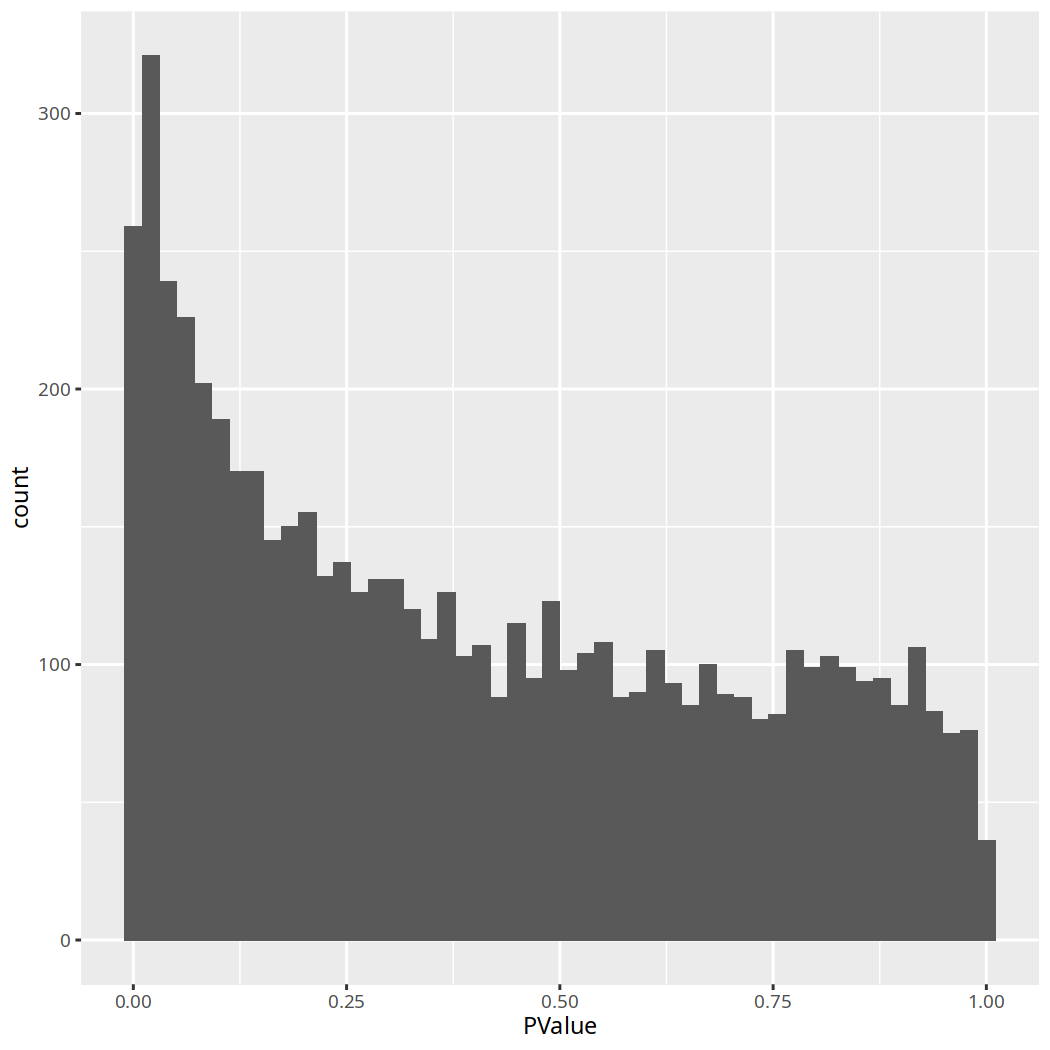

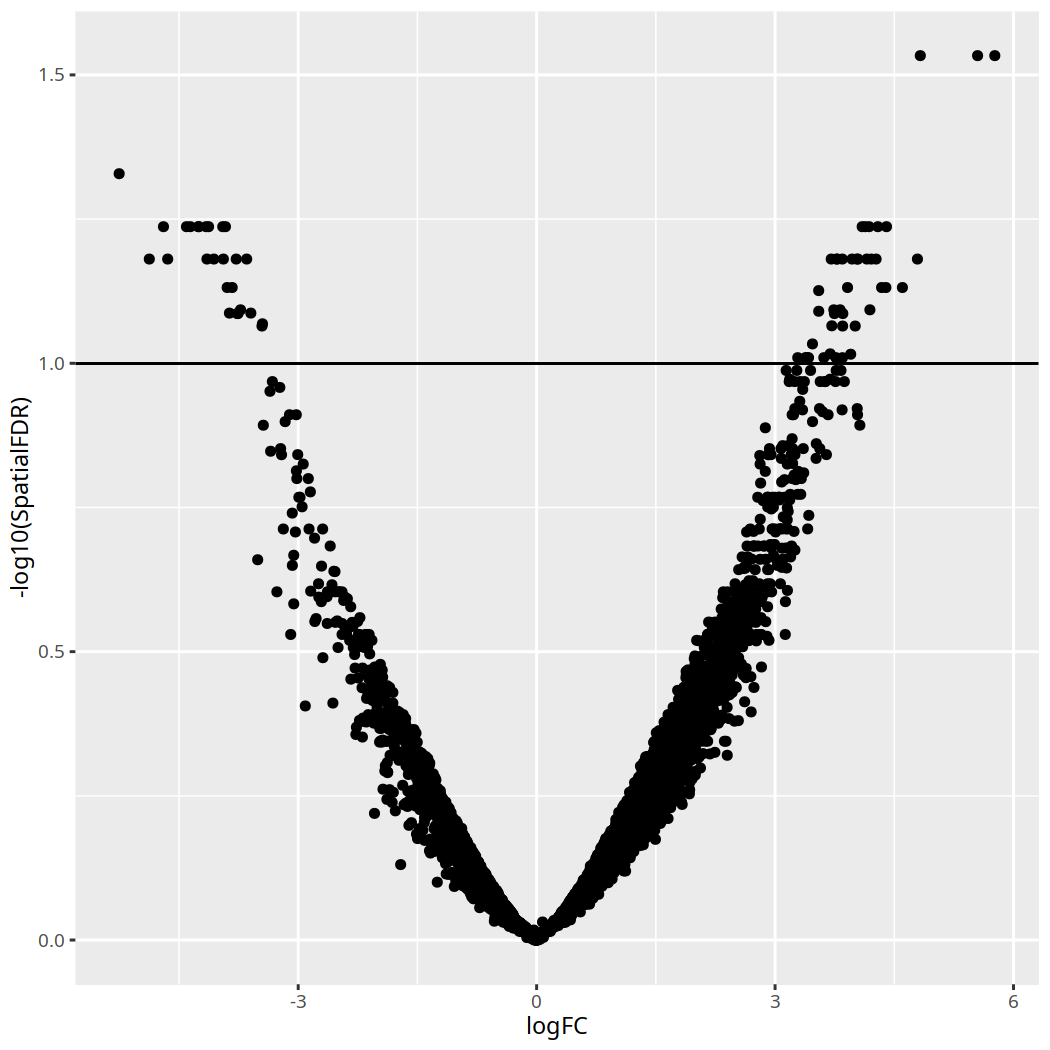

In [13]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) 

milo_obj = buildNhoodGraph(milo_obj)

umap_pl <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="Age_group", 
                          text_by = "annotation_level0", text_size = 3, point_size=0.5) 
+guides(fill="none")

umap_pl2 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="annotation_level0", 
                           text_by = "annotation_level0",text_size = 3, point_size=0.5) +
  guides(fill="none")

umap_pl3 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", 
                           text_by = "DonorID",text_size = 3, point_size=0.5) +
  guides(fill="none")

str(milo_obj)

nh_graph_pl <- plotNhoodGraphDA(milo_obj, da_results, layout="UMAP",alpha=0.1) + 
scale_fill_gradient2(name = "logFC", low = muted("blue"), high = muted("red")) 

nh_plt_comb = umap_pl + nh_graph_pl +
  plot_layout(guides="collect")
ggsave(filename = "~/muscle_ageing/results/Figures/v2_3_rm_343B_ICM_SKM_nbh_plot_myonuclei.png", plot = nh_plt_comb, width = 7.5, height = 6)

In [14]:
da_results <- annotateNhoods(milo_obj, da_results, coldata_col = "annotation_level1")
head(da_results)

Converting annotation_level1 to factor...



logFC      logCPM   F          PValue     FDR       Nhood SpatialFDR
1  0.1707835 8.114037 0.03439667 0.85286601 0.9482300 1     0.9476597 
2  0.8352336 8.352529 0.50898391 0.47558086 0.7815935 2     0.7794642 
3 -2.0378342 7.872755 4.56992333 0.03254065 0.3323047 3     0.3361927 
4 -0.6182868 8.301270 0.34302368 0.55809051 0.8222116 4     0.8204952 
5  1.8049138 8.117262 3.03534962 0.08147234 0.4316292 5     0.4315799 
6  0.4138873 8.304724 0.20204775 0.65307407 0.8717601 6     0.8700297 
  annotation_level1 annotation_level1_fraction
1 I-FAM             0.7594937                 
2 MF-I              0.7891156                 
3 MF-II             0.5857143                 
4 MF-I              0.9047619                 
5 MF-I              0.8584906                 
6 MF-II             0.9082569

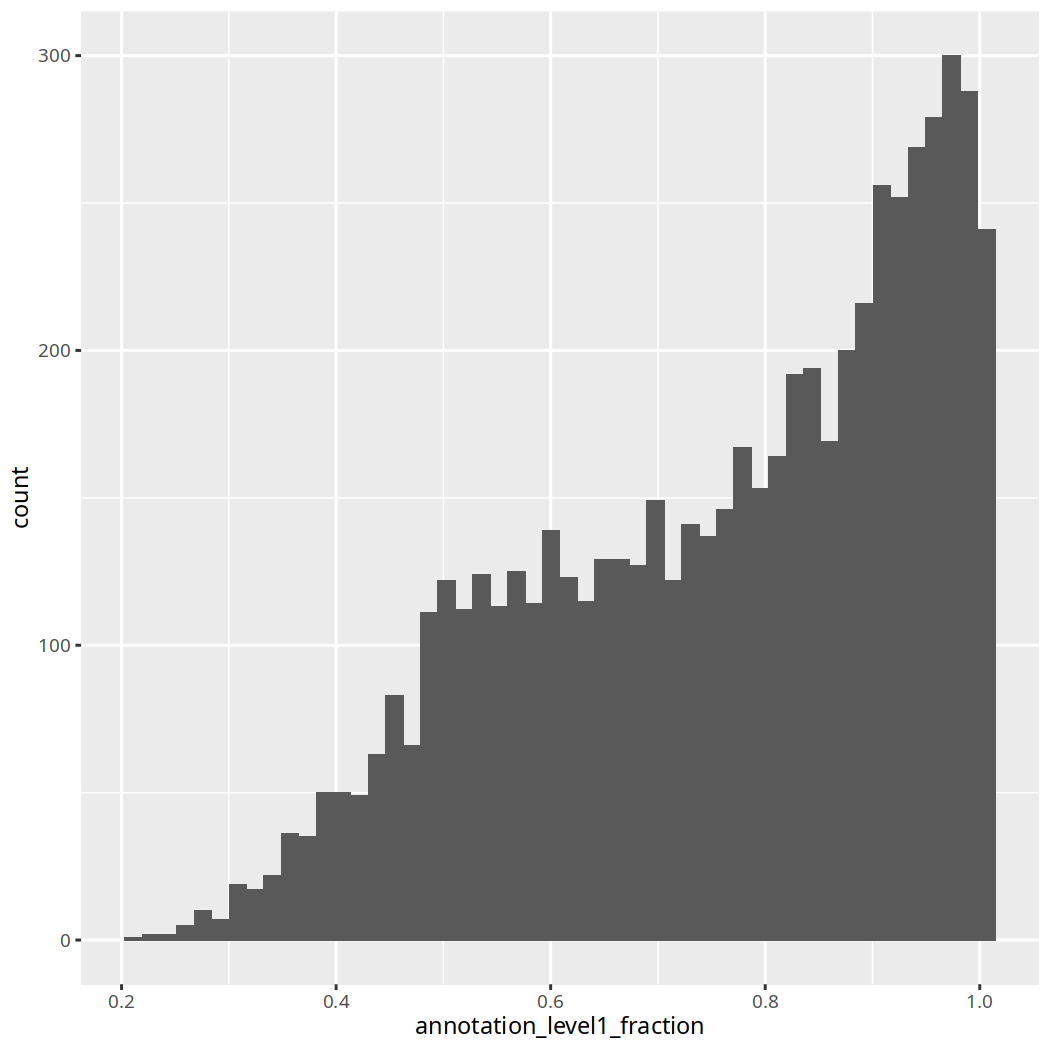

In [15]:
ggplot(da_results, aes(annotation_level1_fraction)) + geom_histogram(bins=50)
da_results$annotation_level1_clean_nhs <- ifelse(da_results$annotation_level1_fraction < 0.7, "Mixed", da_results$annotation_level1)

In [16]:
da_results$annotation_level1_fraction_clean_nhs <- ifelse(da_results$annotation_level1_fraction < 0.7, "Mixed", da_results$annotation_level1)

In [17]:
ctype_order_lev1 = c("MF-I" , "MF-II", "MF-Isn(fg)", "MF-IIsn(fg)", "I-FAM", "II-FAM", "I-OTU+TNF+", "II-OTU+TNF+", "MTJ", "NMJ", "NMJ accessory", "Mixed")

ctype_order_lev0 = c("MF_typeI","MF_typeII","MF_typeI(cytoplasmic)", "MF_typeII(cytoplasmic)","Specialised_MF_populations","Mixed")

In [18]:
da_results$annotation_level1_fraction_clean_nhs = factor(da_results$annotation_level1_fraction_clean_nhs, 
 levels = ctype_order_lev1)

In [19]:
library(ggbeeswarm)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


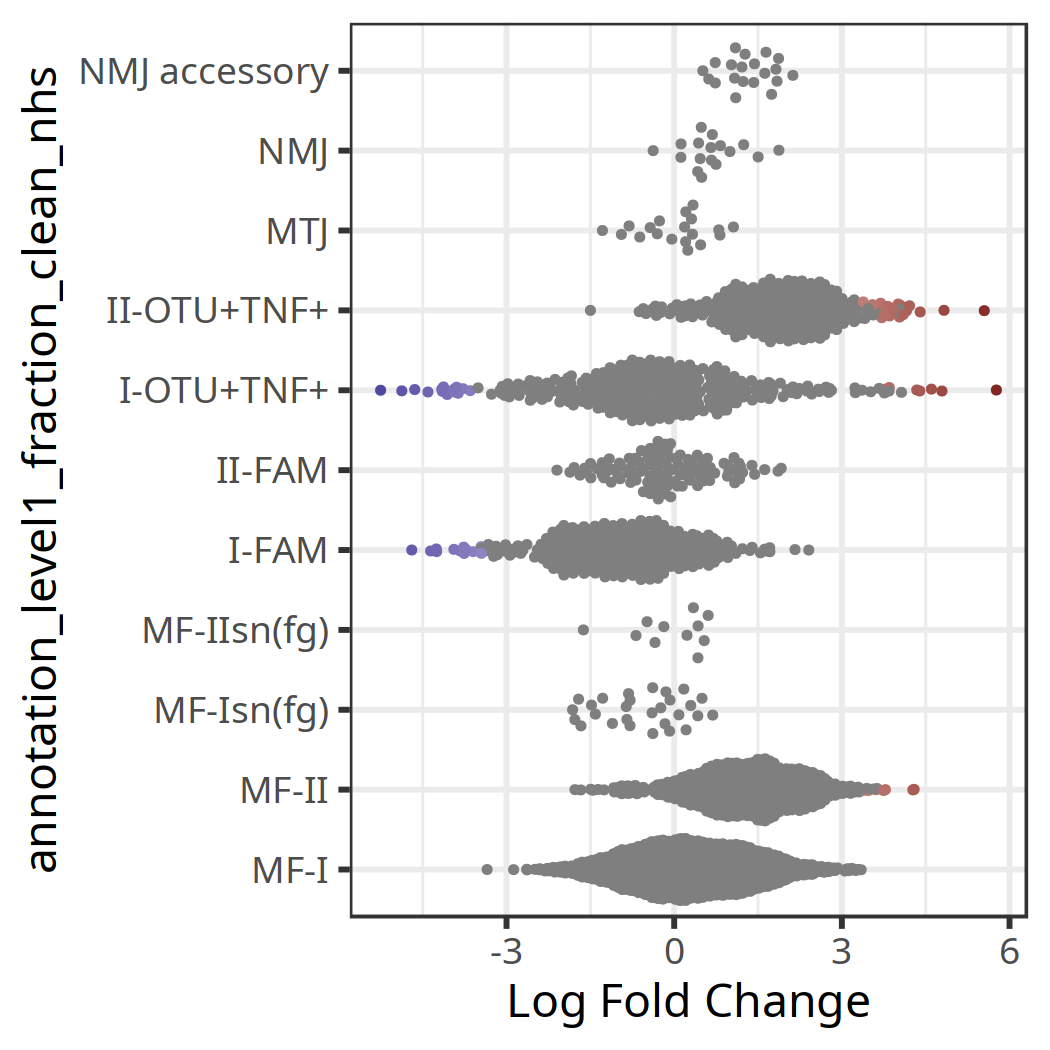

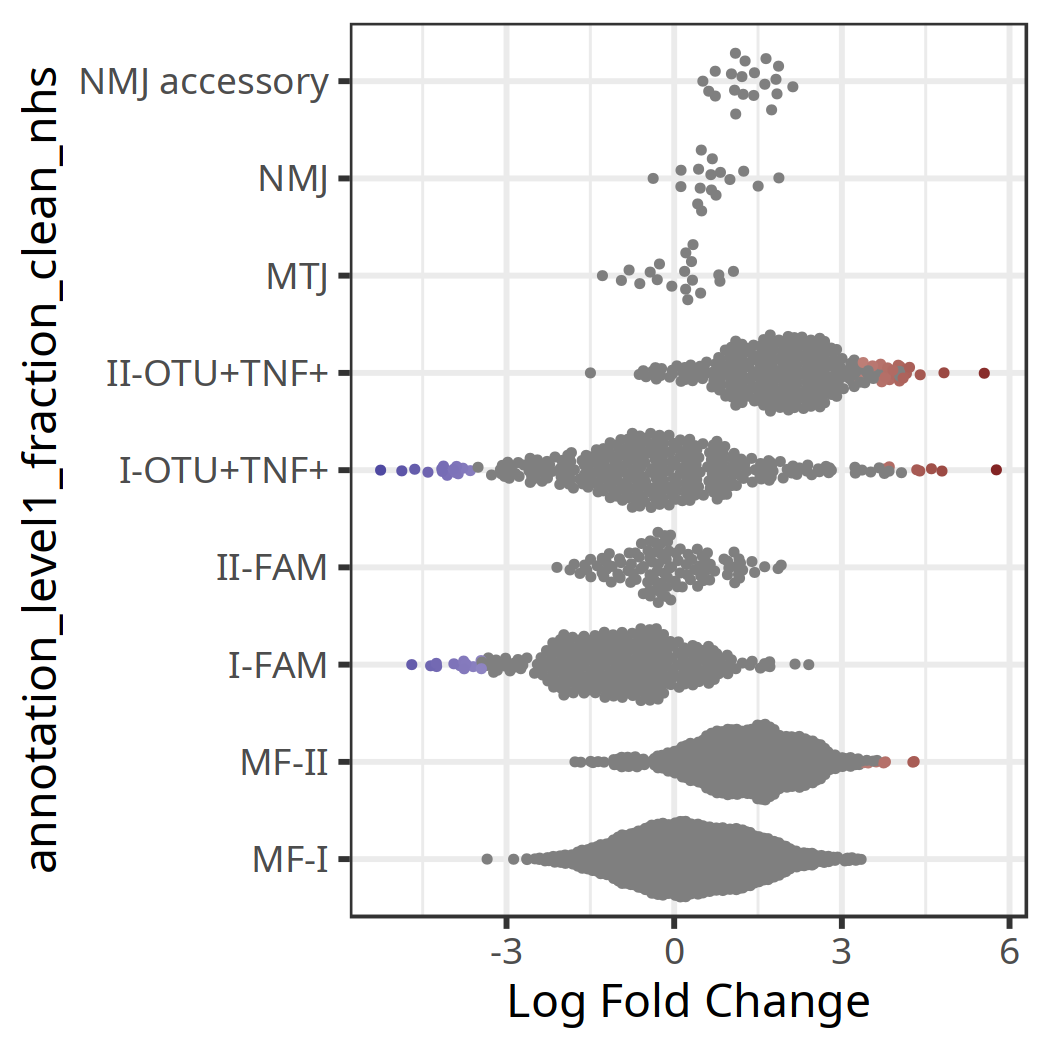

In [20]:
difab_plot = plotDAbeeswarm(da_results, subset.nhoods = da_results$annotation_level1_fraction_clean_nhs!='Mixed', group.by ="annotation_level1_fraction_clean_nhs") +scale_color_gradient2(low = muted("blue"), high = muted("red"))
difab_plot
difab_plot_rm = plotDAbeeswarm(da_results, subset.nhoods = !(da_results$annotation_level1_fraction_clean_nhs %in% c("MF-Isn(fg)", "MF-IIsn(fg)", 'Mixed')), group.by ="annotation_level1_fraction_clean_nhs") +scale_color_gradient2(low = muted("blue"), high = muted("red")) 
difab_plot_rm
#ggsave(filename = "~/muscle_ageing/results/Figures/v2_3_rm_343B_samples_atlas_Dif_abundance_myonuclei_filt.pdf", plot = difab_plot_rm, width = 6, height = 5)

### Code to remove Donor specific neighbourhoods 

In [21]:
da_results2 <- annotateNhoods(milo_obj, da_results, coldata_col = "DonorID")
head(da_results2)

Converting DonorID to factor...



logFC      logCPM   F          PValue     FDR       Nhood SpatialFDR
1  0.1707835 8.114037 0.03439667 0.85286601 0.9482300 1     0.9476597 
2  0.8352336 8.352529 0.50898391 0.47558086 0.7815935 2     0.7794642 
3 -2.0378342 7.872755 4.56992333 0.03254065 0.3323047 3     0.3361927 
4 -0.6182868 8.301270 0.34302368 0.55809051 0.8222116 4     0.8204952 
5  1.8049138 8.117262 3.03534962 0.08147234 0.4316292 5     0.4315799 
6  0.4138873 8.304724 0.20204775 0.65307407 0.8717601 6     0.8700297 
  annotation_level1 annotation_level1_fraction annotation_level1_clean_nhs
1 I-FAM             0.7594937                  I-FAM                      
2 MF-I              0.7891156                  MF-I                       
3 MF-II             0.5857143                  Mixed                      
4 MF-I              0.9047619                  MF-I                       
5 MF-I              0.8584906                  MF-I                       
6 MF-II             0.9082569                  MF-II                      
  annotation_level1_fraction_clean_nhs DonorID DonorID_fraction
1 I-FAM                                583B    0.3544304       
2 MF-I                                 566B    0.3197279       
3 Mixed                                566B    0.3285714       
4 MF-I                                 566B    0.5793651       
5 MF-I                                 367C    0.3018868       
6 MF-II                                464C    0.3394495

### Plot distribution of max donor percentage across all neighbourhoods

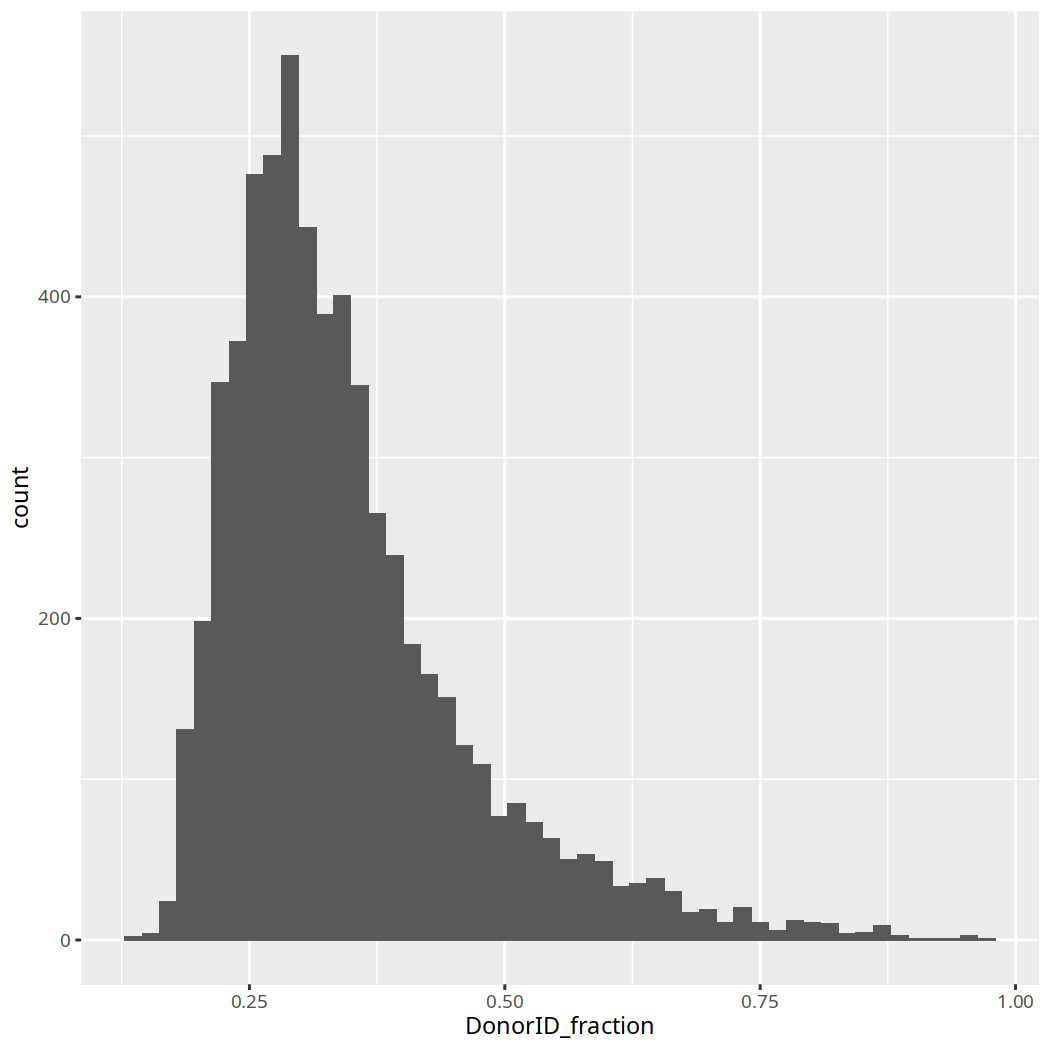

In [22]:
ggplot(da_results2, aes(DonorID_fraction)) + geom_histogram(bins=50) # plot distribution of max donor percentage across 

### Plot distribution of max donor percentage across significant neighbourhoods

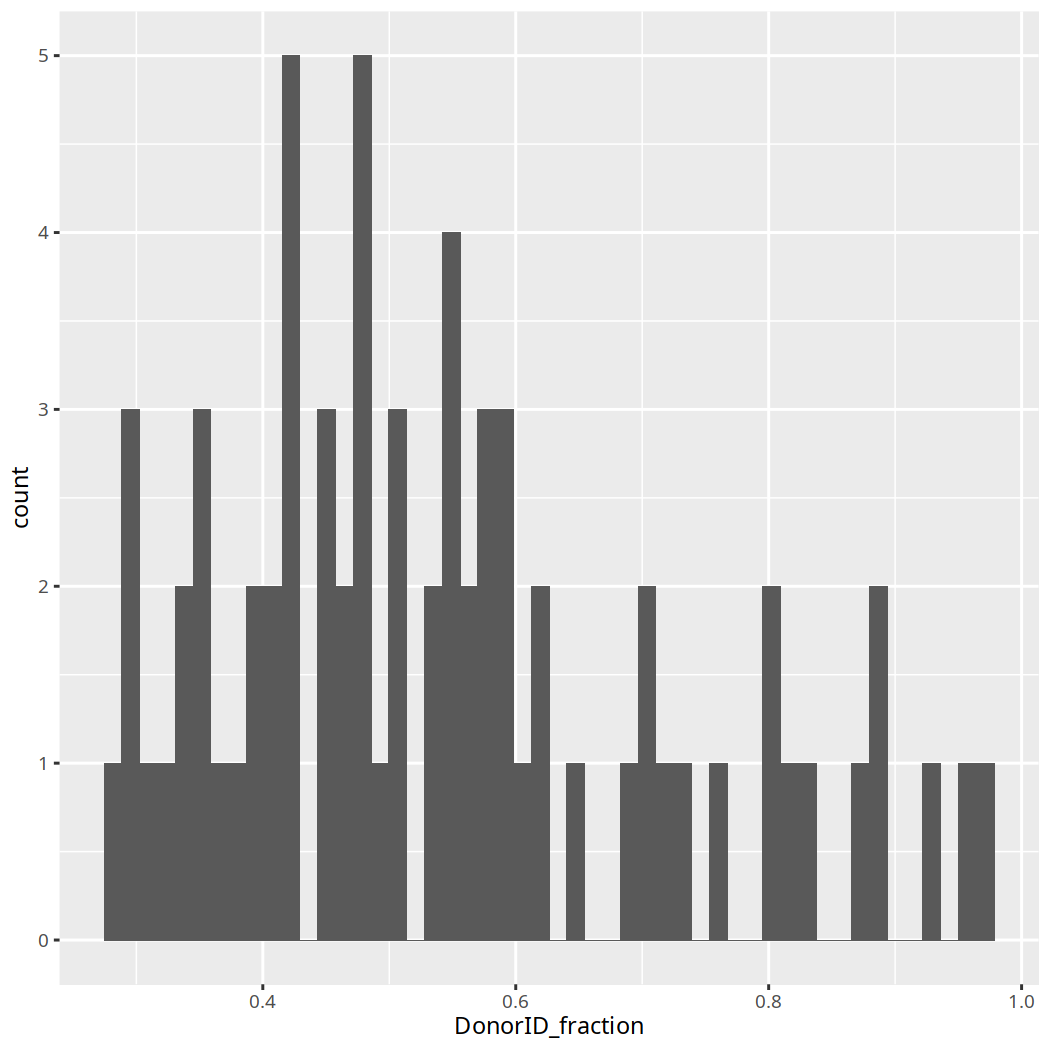

In [23]:
ggplot(da_results2[da_results2$SpatialFDR<0.1,], aes(DonorID_fraction)) + geom_histogram(bins=50)

### Do not display neighbourhoods that have contain more than 90 % cells from one donor on the milo beeswarm plot

In [24]:
da_results2$annotation_level1_clean2 <- ifelse(da_results2$DonorID_fraction > 0.9, "Donor-specific", da_results2$annotation_level1_clean)


In [25]:
sort(table(da_results2$annotation_level1_clean2))


Donor-specific    MF-IIsn(fg)            NMJ            MTJ  NMJ accessory 
             7             11             17             19             20 
    MF-Isn(fg)         II-FAM    II-OTU+TNF+          I-FAM     I-OTU+TNF+ 
            27            107            306            317            328 
         MF-II           MF-I          Mixed 
           931           1866           2179 

In [26]:
c(ctype_order_lev1, "Donor-specific")

[1] "MF-I"           "MF-II"          "MF-Isn(fg)"     "MF-IIsn(fg)"   
 [5] "I-FAM"          "II-FAM"         "I-OTU+TNF+"     "II-OTU+TNF+"   
 [9] "MTJ"            "NMJ"            "NMJ accessory"  "Mixed"         
[13] "Donor-specific"

In [27]:
da_results2$annotation_level1_clean2 = factor(da_results2$annotation_level1_clean2, levels = 
                                             c(ctype_order_lev1, "Donor-specific"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


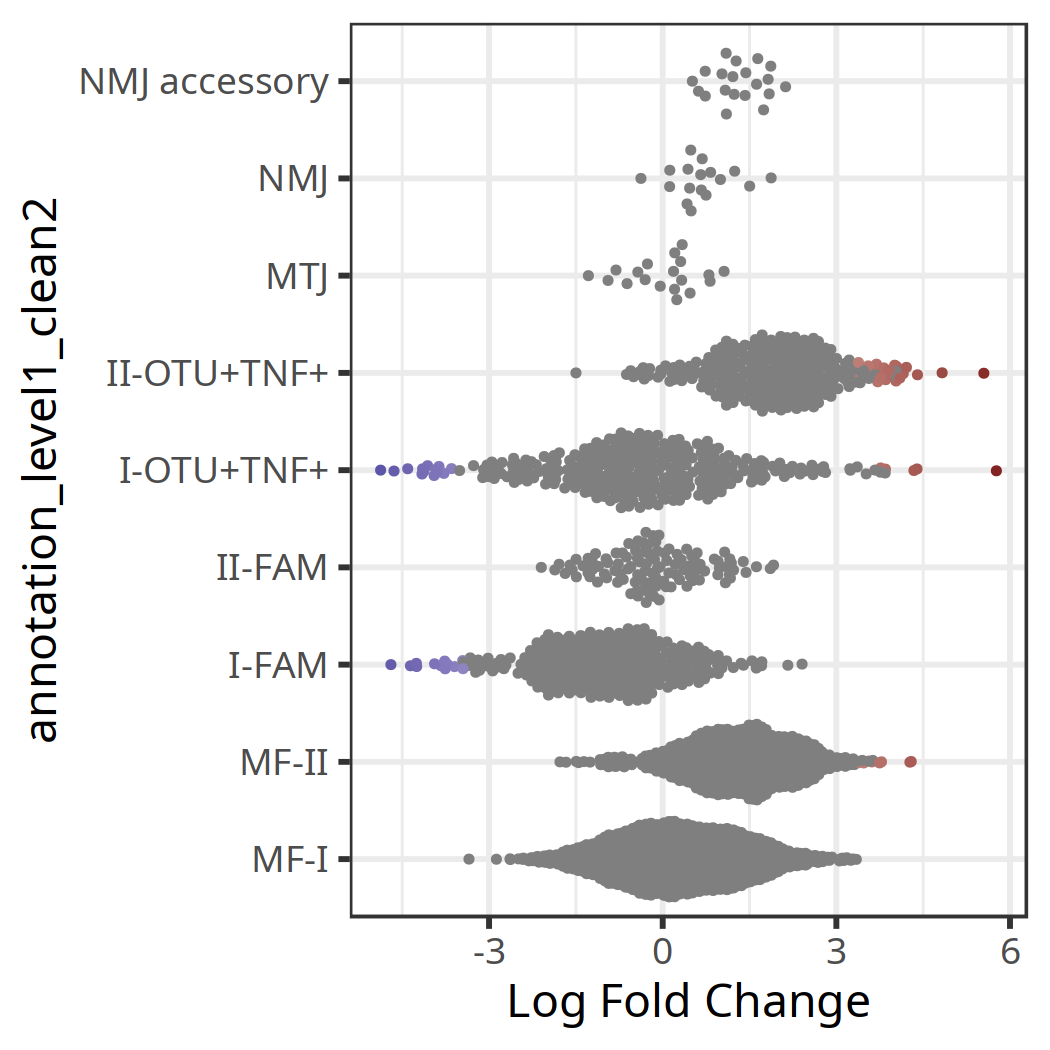

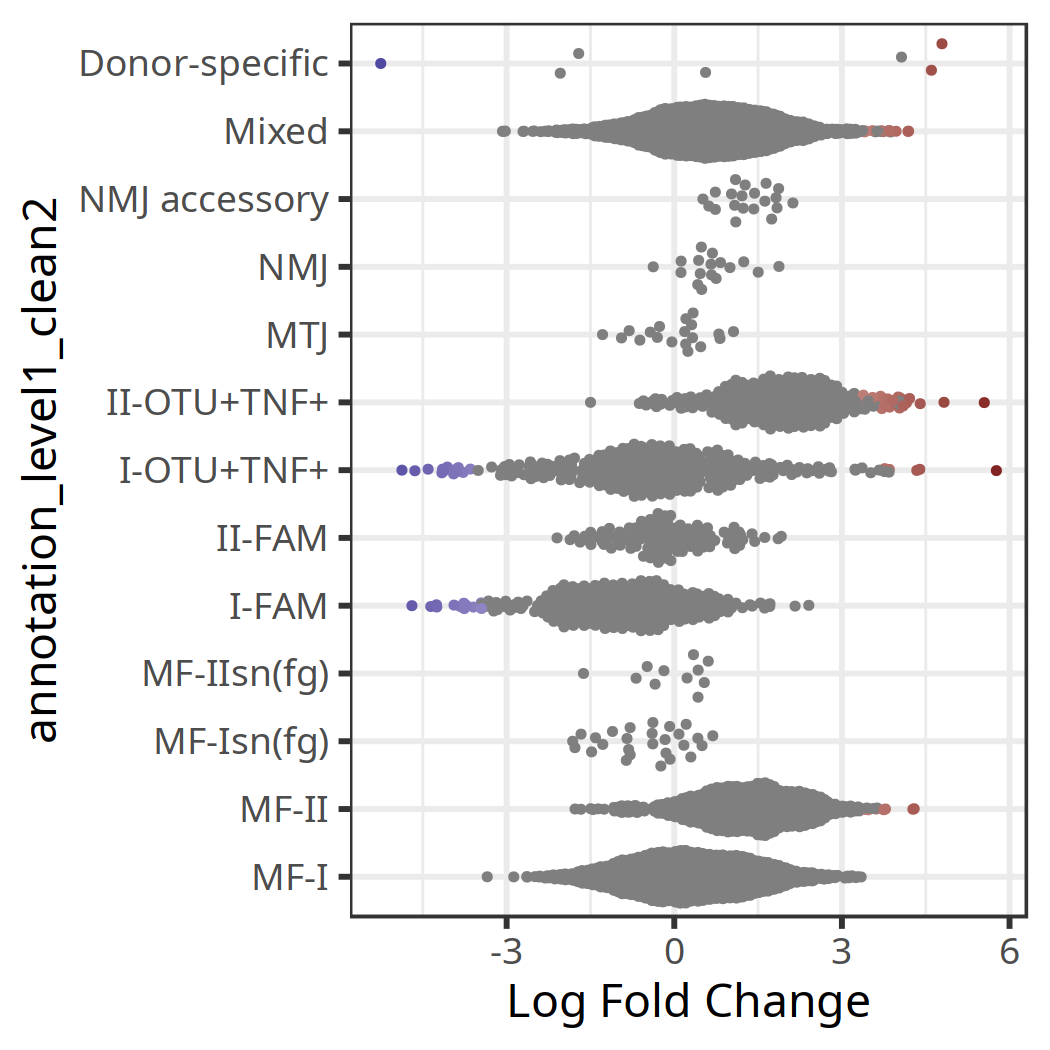

In [28]:
difab_plot_rm = plotDAbeeswarm(da_results2, subset.nhoods = !(da_results2$annotation_level1_clean2 %in% c('Mixed', 'Donor-specific', "MF-Isn(fg)", "MF-IIsn(fg)")), 
                            group.by ="annotation_level1_clean2") +scale_color_gradient2(low = muted("blue"), high = muted("red"))
difab_plot_rm
ggsave(filename = paste0(figures_path, "SKM_myonuclei_343Brm_da_nhds_Donorfilt2.pdf"), plot = difab_plot_rm, width = 6, height = 5)

difab_plot_all = plotDAbeeswarm(da_results2, group.by ="annotation_level1_clean2") +scale_color_gradient2(low = muted("blue"), high = muted("red")) 
difab_plot_all
ggsave(filename = paste0(figures_path, "SKM_myonuclei_da_343Brm_nhds_Donorfilt_all2.pdf"), plot = difab_plot_all, width = 6, height = 5)


### Change LogFC to 0 for Donor-specific and Mixed neighbourhoods  (won't be displayed on umap)

In [29]:
da_results2$logFC2 = ifelse(da_results2$annotation_level1_clean2 %in% c('Mixed', 'Donor-specific'), 0, da_results2$logFC)

In [30]:
milo_obj = buildNhoodGraph(milo_obj)

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


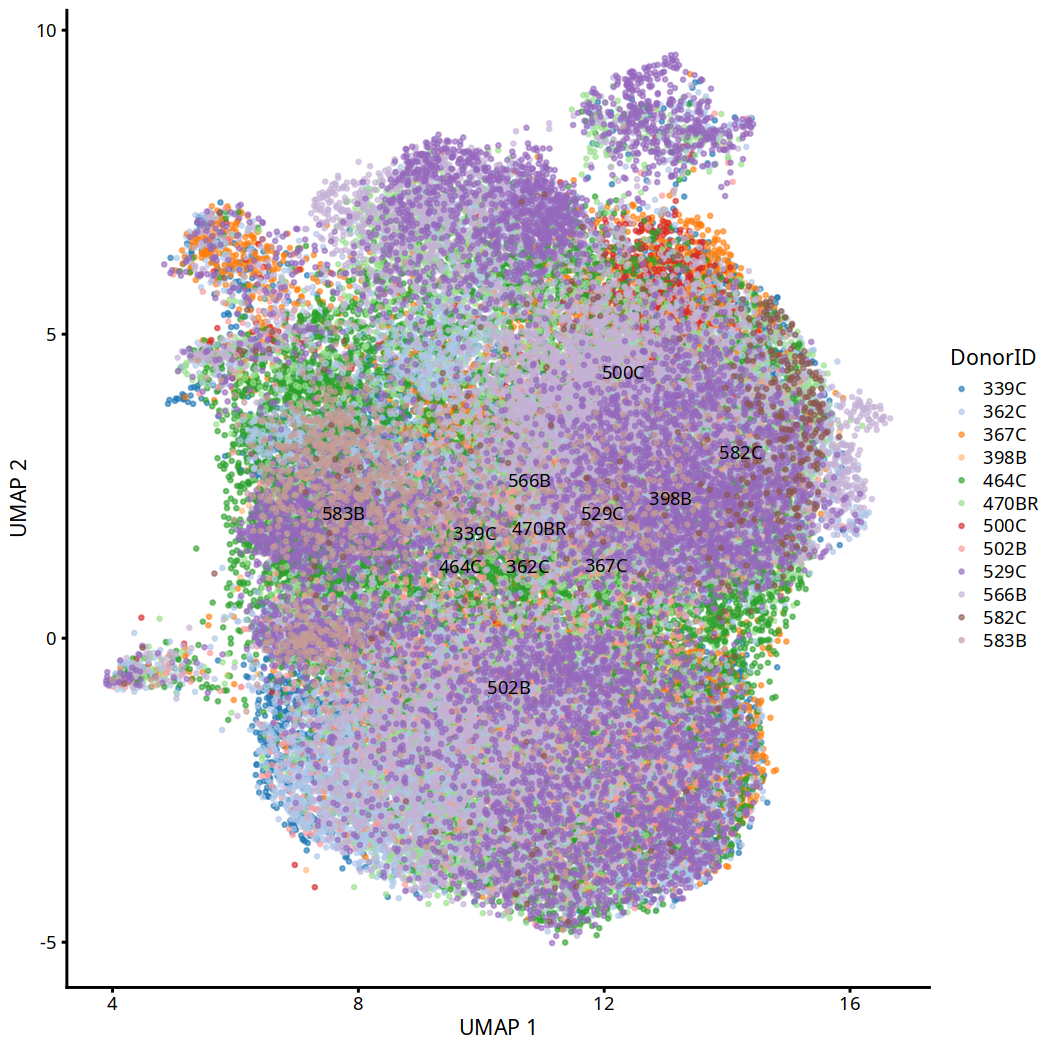

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


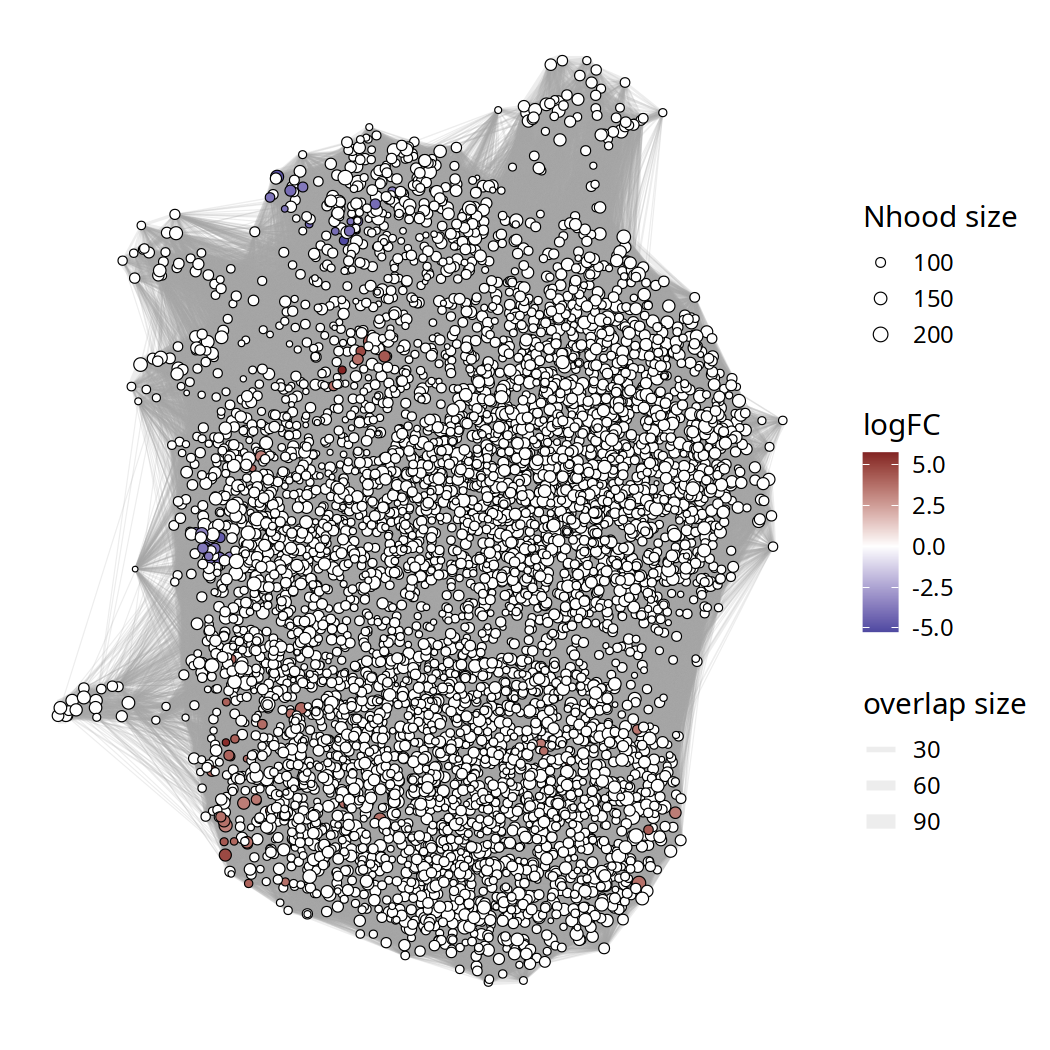

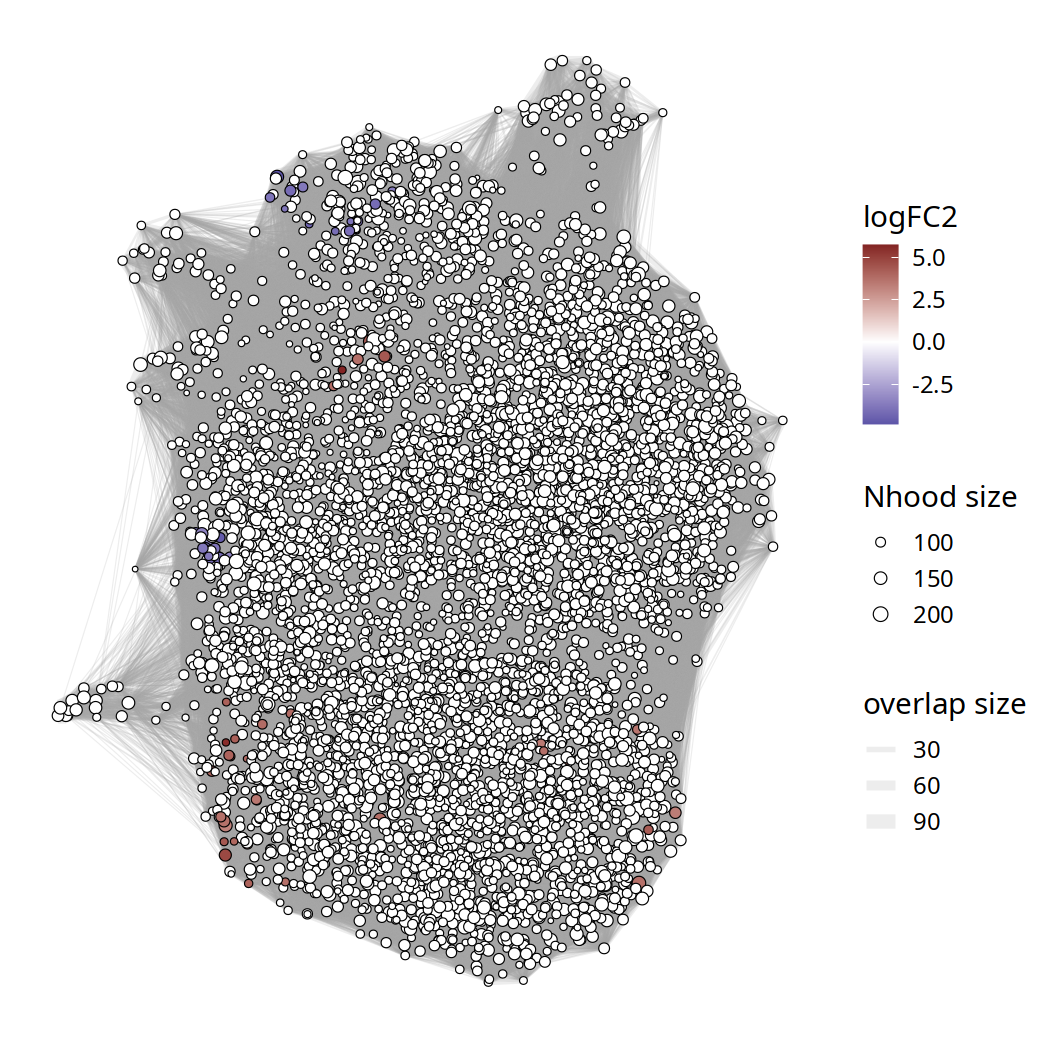

In [32]:
umap_pl <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", 
                           text_by = "DonorID",text_size = 3, point_size=0.5) +
  guides(fill="none")
umap_pl

ggsave(paste0(figures_path, "SKM_myonuclei343BrmUMAP2donor2.pdf"), umap_pl, width = 4.5, height = 4.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are kept in)
nh_graph_pl1 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1) + 
scale_fill_gradient2(name = "logFC", low = muted("blue"), high = muted("red")) 
nh_graph_pl1
ggsave(paste0(figures_path, "SKM_myonuclei343Brm_nhds2.pdf"), nh_graph_pl1, width = 4.5, height = 4.5)
ggsave(paste0(figures_path, "SKM_myonuclei343Brm_nhds2.png"), nh_graph_pl1, width = 4.5, height = 4.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are removed)
nh_graph_pl2 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1, res_column = "logFC2") + 
scale_fill_gradient2(name = "logFC2", low = muted("blue"), high = muted("red"))

nh_graph_pl2
ggsave(paste0(figures_path, "SKM_myonuclei343Brm_nhds_filt2.pdf"), nh_graph_pl2, width = 4.5, height = 4.5)
ggsave(paste0(figures_path, "SKM_myonuclei343Brm_nhds_filt2.png"), nh_graph_pl2, width = 4.5, height = 4.5)
#nh_plt_comb = umap_pl + nh_graph_pl1 +nh_graph_pl2
#  plot_layout(guides="collect")

### Save table with neighbourhoods information

In [33]:
fwrite(da_results2, file = paste0(tables_path,"SKM_myonuclei343Brm_nhds_all.csv"))